# Relative Humidity Prediction

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [2]:
#Read and view the file

df = pd.read_excel('Humidity.xlsx')
df.tail()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250,0.756824
9353,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725,0.711864
9354,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350,0.640649
9355,2005-04-04,13:00:00,2.1,1002.50,-200,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550,0.513866
9356,2005-04-04,14:00:00,2.2,1070.75,-200,11.932060,1047.25,265.2,654.00,167.7,1128.50,816.00,28.500,13.125,0.502804


## EDA and Feature Engineering

1. Read and view the data file.
2. NA values are filled as -200. So replace -200 with np.NaN
3. The feature column NMHC(GT) contains almost 90% NA values so we will delete it.
4. Delete all the rows with NA values.
5. Let us make the year, month and day as 3 new features from the Date column.
6. Extract Hour from time and make it as a new feature. As humidity depends upon time and season these features are very imp.
7. Now delete the Date and Time column.
8. As our target is predicting RH(Relative Humidity), we must drop AH(Absolute Humudity).
9. Use df.info() to make sure all features are numeric and NA values are removed.
10. Use df.isnull().sum() to reconfirm that NA values are completely removed.

In [3]:
# NA values are filled as -200
# So we are replacing -200 with np.NaN

df.replace(to_replace=-200, value=np.NaN, inplace=True)
df.tail()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
9352,2005-04-04,10:00:00,3.1,1314.25,NaN,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250,0.756824
9353,2005-04-04,11:00:00,2.4,1162.50,NaN,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725,0.711864
9354,2005-04-04,12:00:00,2.4,1142.00,NaN,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350,0.640649
9355,2005-04-04,13:00:00,2.1,1002.50,NaN,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550,0.513866
9356,2005-04-04,14:00:00,2.2,1070.75,NaN,11.932060,1047.25,265.2,654.00,167.7,1128.50,816.00,28.500,13.125,0.502804


In [4]:
df.isna().sum()

Date                0
Time                0
CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
dtype: int64

In [5]:
# As we can see that the feature column NMHC(GT) contains almost 90% NA values.
# So we must drop it.

df.drop(['NMHC(GT)'], axis=1, inplace=True)

In [6]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)', 'PT08.S2(NMHC)',
       'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)',
       'T', 'RH', 'AH'],
      dtype='object')

<IPython.core.display.Javascript object>


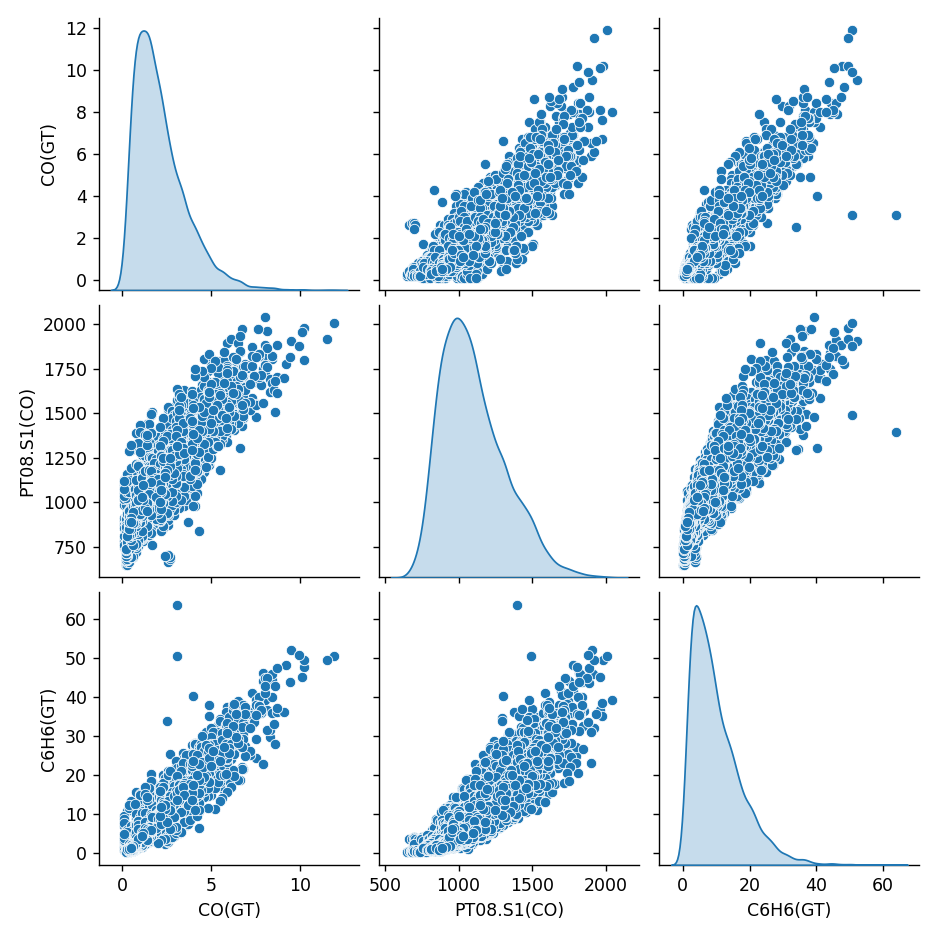

In [7]:
sns.pairplot(df[['CO(GT)', 'PT08.S1(CO)', 'C6H6(GT)']], diag_kind='kde')

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CO(GT),7674.0,2.152750,1.453252,0.100000,1.100000,1.800000,2.900000,11.900000
PT08.S1(CO),8991.0,1099.707856,217.084571,647.250000,936.750000,1063.000000,1231.250000,2039.750000
C6H6(GT),8991.0,10.082993,7.449640,0.149048,4.436942,8.239851,13.988478,63.741476
PT08.S2(NMHC),8991.0,939.029205,266.829000,383.250000,734.375000,909.000000,1116.250000,2214.000000
NOx(GT),7718.0,246.881252,212.971224,2.000000,98.000000,179.800000,326.000000,1479.000000
PT08.S3(NOx),8991.0,835.370973,256.815106,322.000000,657.875000,805.500000,969.250000,2682.750000
NO2(GT),7715.0,113.075515,48.359250,2.000000,78.000000,109.000000,142.000000,339.700000
PT08.S4(NO2),8991.0,1456.143486,346.204540,551.000000,1226.625000,1462.750000,1673.500000,2775.000000
PT08.S5(O3),8991.0,1022.780725,398.480897,221.000000,731.375000,963.250000,1273.375000,2522.750000
T,8991.0,18.316054,8.832888,-1.900000,11.787500,17.750000,24.400000,44.600000


In [9]:
# Let us drop all rows with NA

df.dropna(inplace=True)

In [10]:
df

,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487
2,2004-03-10,20:00:00,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239
3,2004-03-10,21:00:00,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.25,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824
9353,2005-04-04,11:00:00,2.4,1162.50,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864
9354,2005-04-04,12:00:00,2.4,1142.00,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649
9355,2005-04-04,13:00:00,2.1,1002.50,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,13.550000,0.513866


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6941 entries, 0 to 9356
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           6941 non-null   datetime64[ns]
 1   Time           6941 non-null   object        
 2   CO(GT)         6941 non-null   float64       
 3   PT08.S1(CO)    6941 non-null   float64       
 4   C6H6(GT)       6941 non-null   float64       
 5   PT08.S2(NMHC)  6941 non-null   float64       
 6   NOx(GT)        6941 non-null   float64       
 7   PT08.S3(NOx)   6941 non-null   float64       
 8   NO2(GT)        6941 non-null   float64       
 9   PT08.S4(NO2)   6941 non-null   float64       
 10  PT08.S5(O3)    6941 non-null   float64       
 11  T              6941 non-null   float64       
 12  RH             6941 non-null   float64       
 13  AH             6941 non-null   float64       
dtypes: datetime64[ns](1), float64(12), object(1)
memory usage: 813.4+ KB


In [12]:
df.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
dtype: object

In [13]:
# Let us make year, month and day as 3 new features from Date column and also take time as a feature
# As Humididity depends upon time and season these features are very imp.

df['Year'] = pd.to_datetime(df['Date']).dt.year

df['Month'] = pd.to_datetime(df['Date']).dt.month

df['Day'] = pd.to_datetime(df['Date']).dt.day

df['Hour'] = [t.hour for t in df['Time']]

In [14]:
# Now we can delete Date and Time column 
# As our target is predicting RH(Relative Humidity), we must drop AH(Absolute Humudity)

df.drop(['Date', 'Time', 'AH'], axis=1, inplace=True)
df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,Year,Month,Day,Hour
0,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.60,48.875001,2004,3,10,18
1,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.30,47.700000,2004,3,10,19
2,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.90,53.975000,2004,3,10,20
3,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.00,60.000000,2004,3,10,21
4,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.15,59.575001,2004,3,10,22


In [15]:
# Let us make x as features and y as target

x = df.drop(['RH'], axis=1)
y = df['RH']

In [16]:
x

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,Year,Month,Day,Hour
0,2.6,1360.00,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,2004,3,10,18
1,2.0,1292.25,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,2004,3,10,19
2,2.2,1402.00,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,2004,3,10,20
3,2.2,1375.50,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,2004,3,10,21
4,1.6,1272.25,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,2004,3,10,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.25,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,2005,4,4,10
9353,2.4,1162.50,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,2005,4,4,11
9354,2.4,1142.00,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,2005,4,4,12
9355,2.1,1002.50,9.547187,960.50,234.5,701.50,155.7,1041.00,769.75,28.325,2005,4,4,13


In [17]:
y

0       48.875001
1       47.700000
2       53.975000
3       60.000000
4       59.575001
          ...    
9352    29.250000
9353    23.725000
9354    18.350000
9355    13.550000
9356    13.125000
Name: RH, Length: 6941, dtype: float64

In [18]:
x = np.array(x)
y = np.array(y)

In [19]:
# Linear Regression (Ridge regression with l2 regularization(alpha))

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

# Feature Scaling

scaler = MinMaxScaler()

x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

for alpha in [0, 1, 10, 15, 20, 50, 100, 1000]:
    ridge1 = Ridge(alpha=alpha).fit(x_train, y_train)
    print('\nAlpha:' + str(alpha))
    print('Training Accuracy:' + str(ridge1.score(x_train, y_train)))
    print('Testing Accuracy:' + str(ridge1.score(x_test, y_test)))


Alpha:0
Training Accuracy:0.8587530419634801
Testing Accuracy:0.7608840667376381

Alpha:1
Training Accuracy:0.8551697523372844
Testing Accuracy:0.7955863860512207

Alpha:10
Training Accuracy:0.7780210742904391
Testing Accuracy:0.7827925704231897

Alpha:15
Training Accuracy:0.7419210101754158
Testing Accuracy:0.7532286369950568

Alpha:20
Training Accuracy:0.7115638626460381
Testing Accuracy:0.726830390979875

Alpha:50
Training Accuracy:0.5922376587833023
Testing Accuracy:0.6170932050839382

Alpha:100
Training Accuracy:0.48759049643952823
Testing Accuracy:0.5144429612333197

Alpha:1000
Training Accuracy:0.16145814387783963
Testing Accuracy:0.1711407790356747


In [20]:
# Let us take best aplha value

ridge1 = Ridge(alpha=1).fit(x_train, y_train)

# predict on test data

y_pred = ridge1.predict(x_test)

# Evaluate mean absolute percentage error between y_test and y_pred.


from sklearn import metrics

MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred)

Accuracy = 1 - MAPE


print('Percentage Accuracy for Test Data ' + str(Accuracy*100) + ' %')
print('Mean Absolute Percentage Error for Test Data ' + str(MAPE*100) + ' %')

Percentage Accuracy for Test Data 84.74576247163074 %
Mean Absolute Percentage Error for Test Data 15.254237528369249 %


In [21]:
# Polynomial Regression with degree of 2 (Ridge regression with l2 regularization(alpha))

poly = PolynomialFeatures(degree=2)
x_poly2 = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_poly2, y, random_state = 0)

# Feature Scaling

scaler = MinMaxScaler()

x_train_poly2 = scaler.fit_transform(x_train)
x_test_poly2 = scaler.fit_transform(x_test)

for alpha in [0, 1, 10, 15, 20, 50, 100, 1000]:
    ridge2 = Ridge(alpha=alpha).fit(x_train_poly2, y_train)
    print('\nAlpha:' + str(alpha))
    print('Traaining Accuracy:' + str(ridge2.score(x_train_poly2, y_train)))
    print('Testing Accuracy:' + str(ridge2.score(x_test_poly2, y_test)))


Alpha:0
Traaining Accuracy:0.9641400151504069
Testing Accuracy:0.7506200362052734

Alpha:1
Traaining Accuracy:0.9273399582960687
Testing Accuracy:0.8833936928336494

Alpha:10
Traaining Accuracy:0.8758236268755064
Testing Accuracy:0.8534472240582434

Alpha:15
Traaining Accuracy:0.8603781935787789
Testing Accuracy:0.8432446859795232

Alpha:20
Traaining Accuracy:0.8470553937631111
Testing Accuracy:0.8338008793448504

Alpha:50
Traaining Accuracy:0.7873829227674324
Testing Accuracy:0.786819332356024

Alpha:100
Traaining Accuracy:0.7246123153246182
Testing Accuracy:0.7331341560404636

Alpha:1000
Traaining Accuracy:0.4357826360412034
Testing Accuracy:0.4602853203902645


In [22]:
# Let us take best aplha value

ridge2 = Ridge(alpha=1).fit(x_train_poly2, y_train)

# predict on test data

y_pred2 = ridge2.predict(x_test_poly2)

# Evaluate mean absolute percentage error between y_test and y_pred.


from sklearn import metrics

MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred2)

Accuracy = 1 - MAPE

print('Percentage Accuracy for Test Data ' + str(Accuracy*100) + ' %')
print('Mean Absolute Percentage Error for Test Data ' + str(MAPE*100) + ' %')

Percentage Accuracy for Test Data 89.90175192695706 %
Mean Absolute Percentage Error for Test Data 10.098248073042939 %


In [23]:
# Polynomial Regression with degree of 3 (Ridge regression with l2 regularization(alpha))

poly = PolynomialFeatures(degree=3)
x_poly3 = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_poly3, y, random_state = 0)

# Feature Scaling

scaler = MinMaxScaler()

x_train_poly3 = scaler.fit_transform(x_train)
x_test_poly3 = scaler.fit_transform(x_test)

for alpha in [0, 1, 10, 15, 20, 50, 100, 1000]:
    ridge3 = Ridge(alpha=alpha).fit(x_train_poly3, y_train)
    print('\nAlpha:' + str(alpha))
    print('Traaining Accuracy:' + str(ridge3.score(x_train_poly3, y_train)))
    print('Testing Accuracy:' + str(ridge3.score(x_test_poly3, y_test)))


Alpha:0
Traaining Accuracy:0.9830180640156662
Testing Accuracy:-18786280719.586376

Alpha:1
Traaining Accuracy:0.9539228749936606
Testing Accuracy:0.9150530063488073

Alpha:10
Traaining Accuracy:0.9153688006346534
Testing Accuracy:0.9004222989191883

Alpha:15
Traaining Accuracy:0.9046798491634425
Testing Accuracy:0.8913160568255067

Alpha:20
Traaining Accuracy:0.8960357456680317
Testing Accuracy:0.8837490018576283

Alpha:50
Traaining Accuracy:0.8600353037012433
Testing Accuracy:0.852363354215379

Alpha:100
Traaining Accuracy:0.8204070250476092
Testing Accuracy:0.8185548608505291

Alpha:1000
Traaining Accuracy:0.605383271561152
Testing Accuracy:0.6268210372156484


In [24]:
# Let us take best aplha value

ridge3 = Ridge(alpha=1).fit(x_train_poly3, y_train)

# predict on test data

y_pred3 = ridge3.predict(x_test_poly3)

# Evaluate mean absolute percentage error between y_test and y_pred.


from sklearn import metrics

MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred3)

Accuracy = 1 - MAPE

print('Percentage Accuracy for Test Data ' + str(Accuracy*100) + ' %')
print('Mean Absolute Percentage Error for Test Data ' + str(MAPE*100) + ' %')

Percentage Accuracy for Test Data 91.538701742263 %
Mean Absolute Percentage Error for Test Data 8.461298257737006 %


In [25]:
# Random forest regressor

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

Rfr = RandomForestRegressor()

Rfr.fit(x_train, y_train)

RandomForestRegressor()

In [26]:
# predict on test data

y_pred = Rfr.predict(x_test)

# Evaluate mean absolute percentage error between y_test and y_pred.

from sklearn import metrics

MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred)

Accuracy = 1 - MAPE

print('Percentage Accuracy for Test Data ' + str(Accuracy*100) + ' %')
print('Mean Absolute Percentage Error for Test Data ' + str(MAPE*100) + ' %')

Percentage Accuracy for Test Data 91.60861022461421 %
Mean Absolute Percentage Error for Test Data 8.391389775385786 %


In [27]:
# Gradient Boosting Regressor

# Split the dataset in train and test set

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Fit the XGBoost Regression model

xgb = GradientBoostingRegressor()

xgb.fit(x_train, y_train)

GradientBoostingRegressor()

In [28]:
# predict on test data

y_pred = xgb.predict(x_test)

# Evaluate mean absolute percentage error between y_test and y_pred.


from sklearn import metrics

MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred)

Accuracy = 1 - MAPE

print('Percentage Accuracy for Test Data ' + str(Accuracy*100) + ' %')
print('Mean Absolute Percentage Error for Test Data ' + str(MAPE*100) + ' %')

Percentage Accuracy for Test Data 88.98303475762947 %
Mean Absolute Percentage Error for Test Data 11.016965242370526 %


In [29]:
# XGBoost Regressor

from xgboost import XGBRegressor

# Split the dataset in train and test set

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

model = XGBRegressor()

model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [30]:
# predict on test data

y_pred = model.predict(x_test)

# Evaluate mean absolute percentage error between y_test and y_pred.

from sklearn import metrics

MAPE = metrics.mean_absolute_percentage_error(y_test, y_pred)

Accuracy = 1 - MAPE

print('Percentage Accuracy for Test data is ' + str(Accuracy*100) + ' %')

print('\nMean Absolute Percentage Error for Test data is ' + str(MAPE*100) + ' %')

Percentage Accuracy for Test data is 92.88851321753255 %

Mean Absolute Percentage Error for Test data is 7.111486782467445 %


<IPython.core.display.Javascript object>


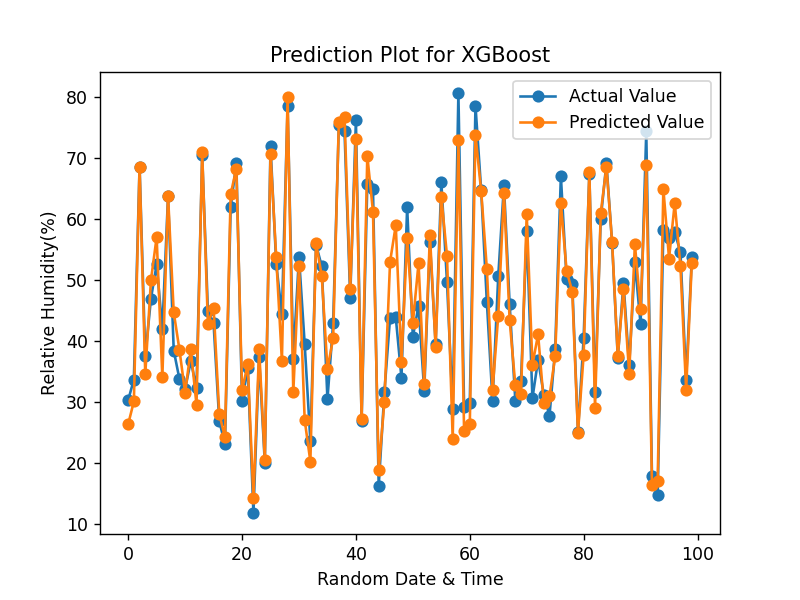

In [33]:
# Plot first 100 samples from y_test and y_pred

xp = np.arange(100)
y_test_plot = y_test[:100] 
y_pred_plot = y_pred[:100]

plt.figure()

plt.plot(xp, y_test_plot, '-o', y_pred_plot, '-o')

plt.xlabel('Random Date & Time')
plt.ylabel('Relative Humidity(%)')
plt.title('Prediction Plot for XGBoost')
plt.legend(['Actual Value', 'Predicted Value'])
plt.savefig('Result.jpg')
plt.show()

<IPython.core.display.Javascript object>


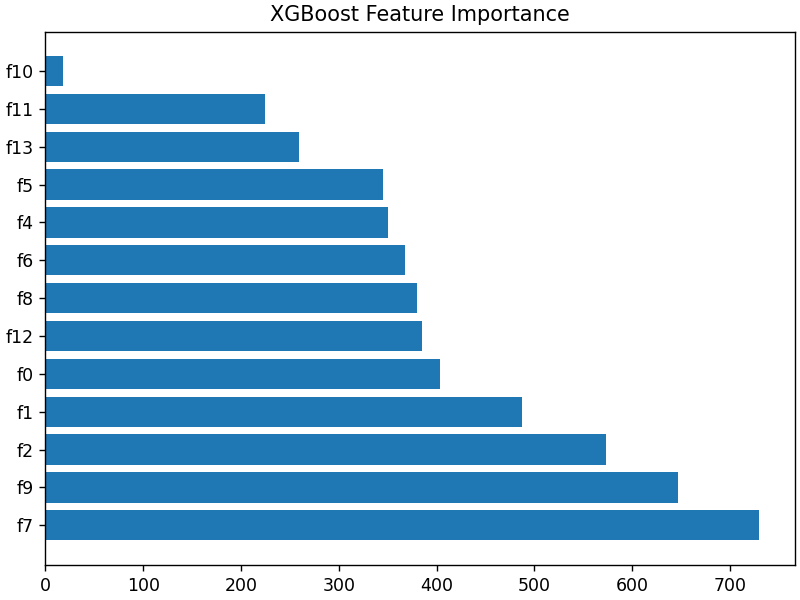

In [32]:
# Let us plot top 15 Important Features 

# Get feature importance data
importance = model.get_booster().get_score(importance_type='weight')

imp_feat = pd.Series(importance.values(), index=importance.keys())
imp_feat1 = imp_feat.sort_values(ascending=False)
imp_feat2 = imp_feat1.iloc[:15]

plt.figure(constrained_layout=True)
xval = range(len(imp_feat2))
plt.barh(xval, imp_feat2, tick_label=imp_feat2.index)
plt.title('XGBoost Feature Importance')
plt.savefig('Imp_Features.jpg')
plt.show()